In [ ]:
# Install the dependancies
!pip install tensorflow
!pip install -q tf-agents
!pip install qiskit 
!pip install numpy

In [ ]:
!pip3 uninstall protobuf --yes
!pip3 uninstall python-protobuf --yes
!pip install protobuf 


# TRAINING 

In [7]:
from environment import QiskitEnv
import numpy as np
from tf_agents.environments import tf_py_environment
from agent import Agent
from qiskit.visualization import plot_bloch_multivector
import matplotlib as plt

# Learning Parameters
num_iterations = 10 

#In an iteration multiple episodes are collected together and a trajectory is built out of it.
#Later these trajectory is used for learning. Trajectory is added to a replay buffer and analysed together.
collect_episodes_per_iteration = 250  #
replay_buffer_capacity = 2000  


learning_rate = 1e-3  
num_eval_episodes = 2  
eval_interval = 5  


"""Environemnt which make use of Qiskit Pulse Simulator and pulse builder to simulate 
the dynamics of a qubit under the influence of a pulse. The RL agent interact with this 
environment through action defined as pulse lenght. Here a constant pulse of amplitude 1 
is used and applied for a time "pulse width". "pulse width" is the action that the agent 
takes here. The agent observes the state obtained with the action along with the Fidelity 
to the expected final state. Here initial state is fixed to |0> and target state is |1>

The pulse is designed as follows
  constant pulse of amplitude 1 for "pulse width" time
  delay the mesearement channel for "pulse width" + 10 time and make mesurement.
TODO: Make the environement more gernect to handle different operators and initial states"""
environment =  QiskitEnv(np.array([1,0]),1)

#convert the python environment to tensorflow compactible format for training.
tf_dumm = tf_py_environment.TFPyEnvironment(environment)
"""Get the reinfoce agent. Reward is the fielily to target state. Observation is the state"""
agent = Agent(num_iterations,collect_episodes_per_iteration,replay_buffer_capacity,learning_rate,num_eval_episodes,eval_interval)
agent_reinforce = agent.get_agent(environment, 'reinforce', "without_noise_trained")
train_results = agent.train(tf_dumm, agent_reinforce)

0 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(4,), dtype=float32) tf.Tensor([0.01512527], shape=(1,), dtype=float32)
1 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(4,), dtype=float32) tf.Tensor([0.01512527], shape=(1,), dtype=float32)
2 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(4,), dtype=float32) tf.Tensor([0.01512527], shape=(1,), dtype=float32)
3 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(4,), dtype=float32) tf.Tensor([0.01512527], shape=(1,), dtype=float32)
4 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(4,), dtype=float32) tf.Tensor([0.01512527], shape=(1,), dtype=float32)
5 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(4,), dtype=float32) tf.Tensor([0.01512527], shape=(1,), dtype=float32)
6 tf.Tensor([ 9.9240857e-01 -3.9653711e-05  1.2153212e-01  1.8847153e-02], shape=(

# Evaluation

Fidelity :  0.8000778697373062
Pulse lenght tf.Tensor([[157]], shape=(1, 1), dtype=int64)
Training avergae return vs step


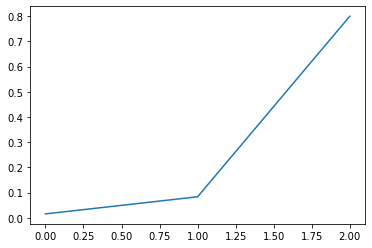

In [8]:
env_test = QiskitEnv(np.array([0,1]),2)
action,fid,vector = agent.evaluate(agent_reinforce, env_test)
print("Fidelity : ", fid)
print("Pulse lenght",action)
plot_bloch_multivector(vector)
print("Training avergae return vs step")
plt.pyplot.plot(train_results[2])

# Load Best Policy

In [9]:
import tensorflow as tf 
import numpy as np
from tensorflow.saved_model import load
from tf_agents import policies
from environment import QiskitEnv
import warnings
import logging, sys
def load_best_policy():
  policy_dir = "best_policy"
  # saved_policy = load(policy_dir)
  # print(saved_policy.action())
  converter = tf.lite.TFLiteConverter.from_saved_model(policy_dir, signature_keys=["action"])
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]
  tflite_policy = converter.convert()
  with open('policy.tflite', 'wb') as f:
    f.write(tflite_policy)


  interpreter = tf.lite.Interpreter("policy.tflite")

  policy_runner = interpreter.get_signature_runner()

  action = policy_runner(**{
      '0/discount':tf.constant(0.0),
      '0/observation':tf.zeros([1,4]),
      '0/reward':tf.constant(0.0),
      '0/step_type':tf.constant(0)})["action"][0][0]
  
  print("\n\n\n\nPulse length : ",action)
  print("Showing the results of the best policy")
  fid, vector = QiskitEnv.get_state(int(action))
  print("Fidelity : ",fid)
  print("Initial State: ", [1,0])
  print("Final State: ", vector)
  print("\n\n")

load_best_policy()





Pulse length :  662
Showing the results of the best policy
Fidelity :  0.9983102421554901
Initial State:  [1, 0]
Final State:  [-0.04110653-1.05800837e-04j  0.92107419+3.87211285e-01j]





2021-10-23 15:27:43.300376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-23 15:27:43.300396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-10-23 15:27:43.300400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-10-23 15:27:43.301241: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: best_policy
2021-10-23 15:27:43.302287: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-10-23 15:27:43.302298: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: best_policy
2021-10-23 15:27:43.306011: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-10-23 15:27:43.321595: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at path: best_policy
2021-10-23 15:27:4